<a href="https://colab.research.google.com/github/Seongjin1225/AI_SCHOOL_9/blob/main/ML%26DL/12%EC%9B%94%2019%EC%9D%BC/12%EC%9B%94_19%EC%9D%BC_%EB%B3%B5%EC%8A%B5ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU 할당 문제로 학습 부분처럼 시간 오래 걸리는 것은 실행 ㄴㄴ

In [ ]:
# 전이학습(Transfer Learning) 구현
# 사용하는 Pretrained Network(Model)은 VGG16(교육용)
# 데이터는 이진분류 데이터(개, 고양이)
# 이미지의 pixel 데이터 추출할때는 ImageDataGenerator를 이용
# Augmentation(증식)까지 포함해서 구현

# 필요 module import
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16


In [ ]:
train_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# validation data는 평가용이므로 증식 X
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 설정
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Pretrainde Network
# include_top = False => feature extractuon 부분만 가져오겠다는 의미
#                        data가 쌓이는 형식이므로 아래 부분이 top이 된다!!
# input_shape의 경우 위에서 150,150으로 임의 설정했지만
# 이미 잘 만들어진 것의 사이즈 굳이 변경할 필요 없으므로 224로 위에 변경

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))
model_base.trainable = False  # 매우 중요한 옵션
                              # Convolution Layer 동결(trainable params가 0이 되도록)
                              # 이 옵션 설정 안할 시, filter가 변경되어 의미가 없어진다
# model_base.summary()

# classifier 구현
model = Sequential()
model.add(model_base)

model.add(Flatten())

model.add(Dense(units=512,
                activation='relu'))

model.add(Dropout(rate=0.5))  # 연산에 사용되는 노드의 절반만 사용 의미

model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrtics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data = validation_generator,
                    validation_steps=50,
                    verbose=1)


In [ ]:
# 시각화 해서 overfitting 확인
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(loss,
         'o',
         color='r',
         label='training loss')
plt.plot(val_loss,
         color='b',
         label='validation loss')
plt.legend()
plt.show()

plt.plot(acc,
         'o',
         color='r',
         label='training acc')
plt.plot(val_acc,
         color='b',
         label='validation acc')
plt.legend()
plt.show()

In [ ]:
# 학습이 끝난 모델을 파일로 저장해놓기(다음에 쉽게 불러 쓰려고)
model.save('/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/12.19.CNN_model.h5')

In [ ]:
# Fine Tuning
# => 모델 학습 끝난 후, 설정을 약간 변형해 재학습 진행
# => 상위 convolution layer의 동결을 풀고 다시 학습을 진행!

# 저장된 파일 불러오기
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/12.19.CNN_model.h5')
# model.summary()

# 여기까지가 한번 Transfer Learning을 이용해서 학습이 완료된 상태예요!
# 추가적인 작업이 필요한데.. 일부 layer에 대한 동결을 해제해야 해요!
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))
model_base.trainable = False

for layer in model_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True  # 이렇게 하면 해당 layer의 동결이 풀려야 되요!
    else:
        layer.trainable = False

model_base.summary()

# 이렇게 모델을 다시 만들고 학습을 한번 더 진행하면 되요!
# => fine tuing! (큰 변화는 아니지만 어느정도 모델의 정확도를 올릴 수 있어요!)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# NLP 부분

In [ ]:
# IMDB Review Data Set을 Loading
# tensorflow keras에는 이미 정수로 변환된 Review 데이터 존재
# 가장 많이 사용하는 단어 500개만 vocabulary로 적재해서 사용
from tensorflow.keras.datasets import imdb
(x_data_train, t_data_train), (x_data_test, t_data_test) = \
imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 0s 0us/step


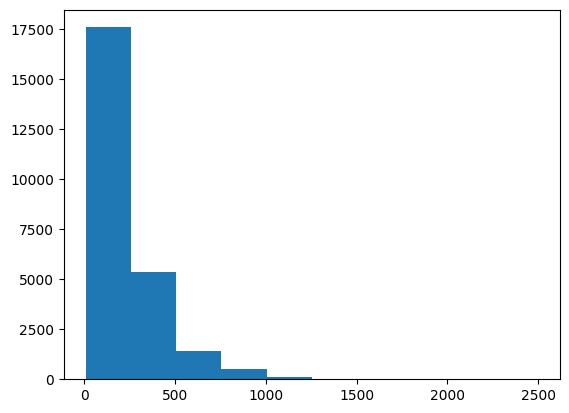

(25000, 100)

In [ ]:
#적재가 완료 되었으니 데이터의 구성을 알아보자

x_data_train.shape
t_data_train.shape
x_data_test.shape
t_data_test.shape
# 확인해보면 4개 모두 (25000,)의 형태 가짐

# train, test data 각각 25000개씩 존재
t_data_train[:10]  # 0,1 둘중에 하나로 나옴! -> 0은 부정 1은 긍정 의미
x_data_train[0]
type(x_data_train) # numpy array
type(x_data_train[0])  # list

# 첫번째 review의 길이(첫번째 Review는 몇개의 단어로 구성되어 있나요?)
len(x_data_train[0])  # 218
# 두번째 review의 길이(두번째 Review는 몇개의 단어로 구성되어 있나요?)
len(x_data_train[1])  # 189

# padding에 대해서 살짝 알아보아요!
# 각 리뷰의 길이 알아보기
import numpy as np
import matplotlib.pyplot as plt

lengths = np.array([len(x) for x in x_data_train])
lengths[:10]

# 모든 review 길이의 평균, 중간값
np.mean(lengths)
np.median(lengths)

# 시각화
plt.hist(lengths)
plt.show()

# 평균, 중앙값, 그래프로 본 결과
# 대부분의 review의 길이는 300이하인것으로 예상
# 실제로는 100 token 미만인 경우가 대다수일 것!

# 모든 review의 길이를 100으로
# 길이가 100 이상인 경우 --> 앞부분 잘라내기
# 길이가 100 이하인 경우 --> padding 사용!(앞에 붙여줌)
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_data_train_seq = pad_sequences(x_data_train, maxlen=100)
type(x_data_train_seq)
x_data_train_seq.shape